In [1]:
import os
username = 'recspert'
repo = 'ITP-SeqRecSys-2024'

# remove local directory if it already exists
if os.path.isdir(repo):
    !rm -rf {repo}

!git clone https://github.com/{username}/{repo}.git

In [2]:
!pip install --no-cache-dir --upgrade git+https://github.com/evfro/polara.git@develop#egg=polara

In [3]:
import numpy as np
import pandas as pd

from polara import get_movielens_data
from polara.preprocessing.dataframes import reindex

from dataprep import transform_indices
from evaluation import topn_recommendations

from scipy.sparse import csr_matrix, coo_matrix
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

In [4]:
def generate_interactions_matrix(data, data_description, rebase_users=False):
    '''
    Converts a pandas dataframe with user-item interactions into a sparse matrix representation.
    Allows reindexing user ids, which help ensure data consistency at the scoring stage
    (assumes user ids are sorted in the scoring array).
    
    Args:
        data (pandas.DataFrame): The input dataframe containing the user-item interactions.
        data_description (dict): A dictionary containing the data description with the following keys:
            - 'n_users' (int): The total number of unique users in the data.
            - 'n_items' (int): The total number of unique items in the data.
            - 'users' (str): The name of the column in the dataframe containing the user ids.
            - 'items' (str): The name of the column in the dataframe containing the item ids.
            - 'feedback' (str): The name of the column in the dataframe containing the user-item interaction feedback.
        rebase_users (bool, optional): Whether to reindex the user ids to make contiguous index starting from 0. Defaults to False.

    Returns:
        scipy.sparse.csr_matrix: A sparse matrix of shape (n_users, n_items) containing the user-item interactions.
    '''

    data_sorted = data.sort_values(by=[data_description['timestamp']])
    data_sorted['reciprocal_rank'] = 1.0 / (data_sorted.groupby(data_description['users']).cumcount(ascending=False) + 1)
    
    n_users = data_description['n_users']
    n_items = data_description['n_items']
    # get indices of observed data
    user_idx = data_sorted[data_description['users']].values
    if rebase_users: # handle non-contiguous index of test users
        # This ensures that all user ids are contiguous and start from 0,
        # which helps ensure data consistency at the scoring stage.
        user_idx, user_index = pd.factorize(user_idx, sort=True)
        n_users = len(user_index)
    item_idx = data_sorted[data_description['items']].values
    feedback = np.ones_like(item_idx)
    # construct rating matrix
    return csr_matrix((feedback, (user_idx, item_idx)), shape=(n_users, n_items), dtype='f8')

In [5]:
# Good old MovieLens-1M

data = get_movielens_data(include_time=True)

data_description = {
    'users':'userid',
    'items':'movieid',
    'feedback':'rating',
    'timestamp':'timestamp'
}

# Data split

![alt text](./plots/split.png "Logo Title Text 1")

In [6]:
# define the timepoint corresponding to the 95% percentile
test_timepoint = data['timestamp'].quantile(
    q=0.95, interpolation='nearest'
)

# interaction after timepoint go to test
test_data_ = data.query('timestamp >= @test_timepoint')
# interaction before timepoint go to train,
# also hiding the interactions of test users
# this ensures the warm-start strategy
train_data_ = data.query(
    'userid not in @test_data_.userid.unique() and timestamp < @test_timepoint'
)

In [7]:
test_timepoint

993074159

In [8]:
train_data_

,userid,movieid,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
...,...,...,...,...
999863,6039,1081,4,956705989
999864,6039,1083,3,956706051
999865,6039,1086,4,956706182
999866,6039,1088,4,956706019


In [9]:
test_data_

,userid,movieid,rating,timestamp
2327,19,318,4,994556598
2492,19,1234,5,994556636
2503,20,1694,3,1009669071
2504,20,2641,4,1009669115
2507,20,3527,4,1009669181
...,...,...,...,...
1000126,6040,1333,4,997454140
1000162,6040,3362,4,997453796
1000167,6040,161,3,997454486
1000169,6040,2725,4,997454180


In [10]:
# transform user and item ids for convenience, reindex test data
training, data_index = transform_indices(train_data_.copy(), 'userid', 'movieid')

# reindex items in test set, if item was not in train, assign -1 as itemid
test_data = reindex(test_data_, data_index['items'], filter_invalid=False)

# Successive evaluation

![alt text](./plots/eval.png "Logo Title Text 1")

In [11]:
# the items that were not in the training set have itemid -1
# let's drop the items with itemid -1 and all consequtive interactions
test_data = test_data.sort_values(by=[data_description['users'], data_description['timestamp']])
mask = test_data.groupby(data_description['users']).cummin()[data_description['items']] == -1
test_data_truncated = test_data[~mask]

# also get rid of users who have just 1 interaction
interaction_counts = test_data_truncated.groupby(data_description['users']).size()
users_to_keep = interaction_counts[interaction_counts >= 2].index
test_prepared = test_data_truncated[test_data_truncated[data_description['users']].isin(users_to_keep)]


In [12]:
# split the data into validation and test by users

unique_users = test_prepared[data_description['users']].unique()
np.random.shuffle(unique_users)

# split the users into two halves
split_index = len(unique_users) // 2
users_val = unique_users[:split_index]
users_test = unique_users[split_index:]

# create val and test
test = test_prepared[test_prepared[data_description['users']].isin(users_test)]
val = test_prepared[test_prepared[data_description['users']].isin(users_val)]

To perform successive evaluation, we need to have access to the user's history in chronological order. Let's create a dictionary with users as keys

In [13]:
test_dict = {}
for user, item, rating, timestamp in test.values:
    ...

In [14]:
test_dict

{19: [308, 1123],
 20: [1529, 1334, 3425, 2610, 2399, 1254, 3458, 3244, 1382, 1128, 1250],
 23: [2720,
  1146,
  1094,
  1112,
  1000,
  3117,
  836,
  1747,
  2467,
  2796,
  3447,
  2399,
  1935,
  2376,
  3242,
  2034,
  2180,
  2181,
  316,
  1267,
  2182,
  2400,
  1936,
  1906,
  2401],
 36: [252,
  524,
  1088,
  787,
  1111,
  953,
  538,
  1743,
  1981,
  1152,
  2298,
  3410,
  1011,
  3138,
  2398,
  572,
  2845,
  1253,
  3344,
  2698,
  3289,
  1790,
  589,
  2557,
  1255,
  2735,
  282,
  2047,
  1802,
  490,
  357,
  1892,
  2376,
  1451,
  1441,
  3198,
  1180,
  6,
  1266,
  1091,
  1179,
  1954,
  2701,
  1902,
  1702,
  2420,
  2731,
  2296,
  191,
  1046,
  562,
  2883,
  539,
  1082,
  3082,
  536,
  1171,
  3530,
  2529,
  2044,
  1533,
  2450,
  3490,
  2140,
  2468,
  2913,
  286,
  239,
  1154,
  575,
  1183,
  3348],
 44: [3502,
  1482,
  477,
  2376,
  2318,
  526,
  1403,
  1420,
  1897,
  690,
  3333,
  2454,
  567,
  825,
  2982,
  1756,
  2624,
  3184,
  

# Simple Association Rules (AR)

$$
\text{score}_{AR}(u, i) = \text{PairCount}_{AR}(i_{|I_u|}, i)
$$

$$
\text{PairCount}_{AR}(i, j) = |U_i\cap U_j|
$$

$I_u$ - interaction history of user $u$, $U_i$ - set of users who interacted with item $i$, $i_{|I_u|}$ - last item of user $u$

In [15]:
from scipy.sparse import diags

class AR:
    def __init__(self, model_config=None) -> None:
        pass
    
    def build(self, data, data_description):
        '''
        Builds association rules matrix.
        '''
        self.rules = ...
        
    def recommend(self, data, data_description):
        '''
        Generate scores for given data.
        '''
        # Drop duplicates, keeping the last interaction for each user
        
        scores = ...
        return scores

    def recommend_sequential(self, target_seq, seen_seq, user):
        '''
        Generate scores for sequential evaluation - 
        subsequently add 1 item from target sequence to the seen sequence
        and generate predictions for the resulting history.
        '''
        
        scores_seq = ...
        return scores_seq

# Sequential Rules (MC)

$$
\text{score}_{SR}(u, i) = \sum_{j \in I_u  \backslash \{i\}} \textbf{1}[j=i_{|I_u|}]\text{PairCount}_{SR}(j \rightarrow i)
$$

$$
\text{PairCount}_{SR}(j \rightarrow i) = \sum_{v\in U} \textbf{1}[j\rightarrow_v i]
$$

where $j\rightarrow_u i$ means that item $i$ follows item $j$ in the interaction history of user $u$. $U$ is the set of users

In [16]:
class SR:
    def __init__(self, model_config=None) -> None:
        pass
    
    def build(self, data, data_description):
        'Builds sequential rules of size two'
        
        self.rules = ...

    def recommend(self, data, data_description):
        '''
        Generate scores for given data.
        '''
        scores = ...
        return scores
    
    def recommend_sequential(self, target_seq, seen_seq, user):
        '''
        Generate scores for sequential evaluation - 
        subsequently add 1 item from target sequence to the seen sequence
        and generate predictions for the resulting history.
        '''
        scores = ...
        return scores

# Baselines

To compare the performance of our Association and Sequential Rule methods we should also build some baselines - random and popular-based. This also serves as sanity check for our models.

In [17]:
class Random:
    def __init__(self, model_config=None) -> None:
        # for reproducibility, not a hyperparameter
        self.seed = model_config['seed']
        self.rng = np.random.default_rng(seed=model_config['seed'])
    
    def build(self, data, data_description):
        self.n_items = data_description['n_items']
        
    def recommend(self, data, data_description):
        n_users = data.nunique()[data_description['users']]
        n_items = data_description['n_items']
        return self.rng.random((n_users, n_items))
    
    def recommend_sequential(self, target_seq, seen_seq, user):
        return self.rng.random((len(target_seq), self.n_items))

In [18]:
class Popular:
    def __init__(self, model_config=None) -> None:
        pass
    
    def build(self, data, data_description):
        item_popularity = data[data_description['items']].value_counts()
        n_items = item_popularity.index.max() + 1
        popularity_scores = np.zeros(n_items,)
        popularity_scores[item_popularity.index] = item_popularity.values
        self.popularity_scores = popularity_scores
        
    def recommend(self, data, data_description):
        n_users = data.nunique()[data_description['users']]
        return np.tile(self.popularity_scores, (n_users, 1))
    
    def recommend_sequential(self, target_seq, seen_seq, user):
        return np.tile(self.popularity_scores, (len(target_seq), 1))

In [19]:
def downvote_seen_items_sequence(scores, seen_sequence):
    assert isinstance(scores, np.ndarray), 'Scores must be a dense numpy array!'
    assert scores.shape[0] == len(seen_sequence), 'Scores size is different from sequence length!'
    
    ...

In [20]:
def successive_evaluation(test_dict, model, topn=10):
    cum_hits = 0
    cum_reciprocal_ranks = 0.
    cum_discounts = 0.
    unique_recommendations = set()
    total_count = 0
    
    for user in tqdm(test_dict):
        seen_seq = ...
        test_seq = ...
        num_predictions = len(test_seq)
        if not num_predictions: # if no test items left - skip user
            continue
        scores = model.recommend_sequential(test_seq, seen_seq, user)
        downvote_seen_items_sequence(scores, test_dict[user][:-1])
        predicted_items = topn_recommendations(scores, topn=topn)
        
        hit_steps, hit_index = np.where(predicted_items == np.atleast_2d(test_seq).T)
        unique_recommendations.update(predicted_items.ravel())

        num_hits = hit_index.size
        if num_hits:
            cum_hits += num_hits
            cum_reciprocal_ranks += np.sum(1. / (hit_index+1))
            cum_discounts += np.sum(1. / np.log2(hit_index+2))

        total_count += num_predictions

    hr = cum_hits / total_count
    mrr = cum_reciprocal_ranks / total_count
    dcg = cum_discounts / total_count
    cov = len(unique_recommendations) / scores.shape[1]
    results = pd.DataFrame(
        data = {f'{model.__class__.__name__}': [hr, mrr, dcg, cov]},
        index = [f'{metric}@{topn}' for metric in ['HR', 'MRR', 'NDCG', 'COV']]
    )
    return results
        
        

In [21]:
data_description_rules = {
    'n_users':training.nunique()['userid'],
    'n_items':training.nunique()['movieid'],
    'users':'userid',
    'items':'movieid',
    'feedback':'rating',
    'timestamp':'timestamp'
}

In [22]:
ar_model = AR()
ar_model.build(training, data_description_rules)
results_ar = successive_evaluation(test_dict, ar_model)

  0%|          | 0/386 [00:00<?, ?it/s]

In [23]:
sr_model = SR()
sr_model.build(training, data_description_rules)
results_sr = successive_evaluation(test_dict, sr_model)

  0%|          | 0/386 [00:00<?, ?it/s]

In [24]:
pop_model = Popular()
pop_model.build(training, data_description_rules)
results_pop = successive_evaluation(test_dict, pop_model)

  0%|          | 0/386 [00:00<?, ?it/s]

In [25]:
rand_model = Random({'seed':0})
rand_model.build(training, data_description_rules)
results_rand = successive_evaluation(test_dict, rand_model)

  0%|          | 0/386 [00:00<?, ?it/s]

In [26]:
pd.concat([results_sr, results_ar, results_pop, results_rand], axis=1).T

,HR@10,MRR@10,NDCG@10,COV@10
SR,0.085336,0.033709,0.045688,0.849124
AR,0.041984,0.014166,0.020583,0.246714
Popular,0.018384,0.005518,0.008471,0.008762
Random,0.002180,0.000652,0.001000,1.000000


What can be done to improve model's quality?
- Allow counting not consequent pairs of items (e.g. count $\textbf{A} \rightarrow \textbf{B}$ and $\textbf{A}\rightarrow \text{C} \rightarrow \text{D} \rightarrow \textbf{B}$, probably with weighting proportional to the inverse number of items between the pair)
- This also may help in the case of sparse datasets, where there is hard to mine association rules (density of ML-1m is about $4\%$, which is pretty high)

As we can see, apart from better accuracy metrics (HR and MRR), the sequential rules model provides much more diverse recommendations.

Let's look at the sparsity of rules matrices

In [27]:
print(f'AR rules density: {ar_model.rules.size / ar_model.rules.shape[0] ** 2:.2f}')
print(f'SR rules density: {sr_model.rules.size / sr_model.rules.shape[0] ** 2:.2f}')

AR rules density: 0.76
SR rules density: 0.03


Here is the sparsity pattern of the left 100 $\times$ 100 corner of rules matrix

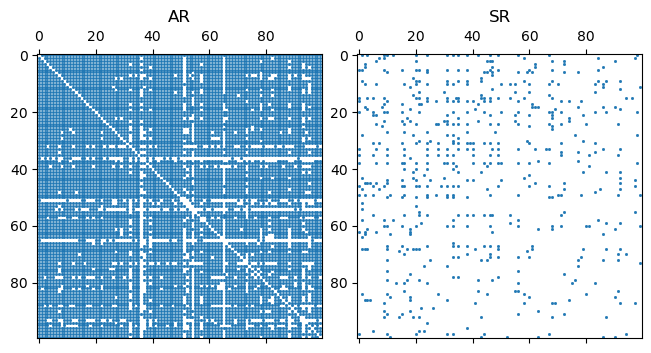

In [28]:
fig, ax = plt.subplots(1, 2, constrained_layout=True)
ax[0].spy(ar_model.rules[:100, :100], markersize=1, label='AR')
ax[0].set_title('AR')
ax[1].spy(sr_model.rules[:100, :100], markersize=1, label='SR')
ax[1].set_title('SR')
plt.show()

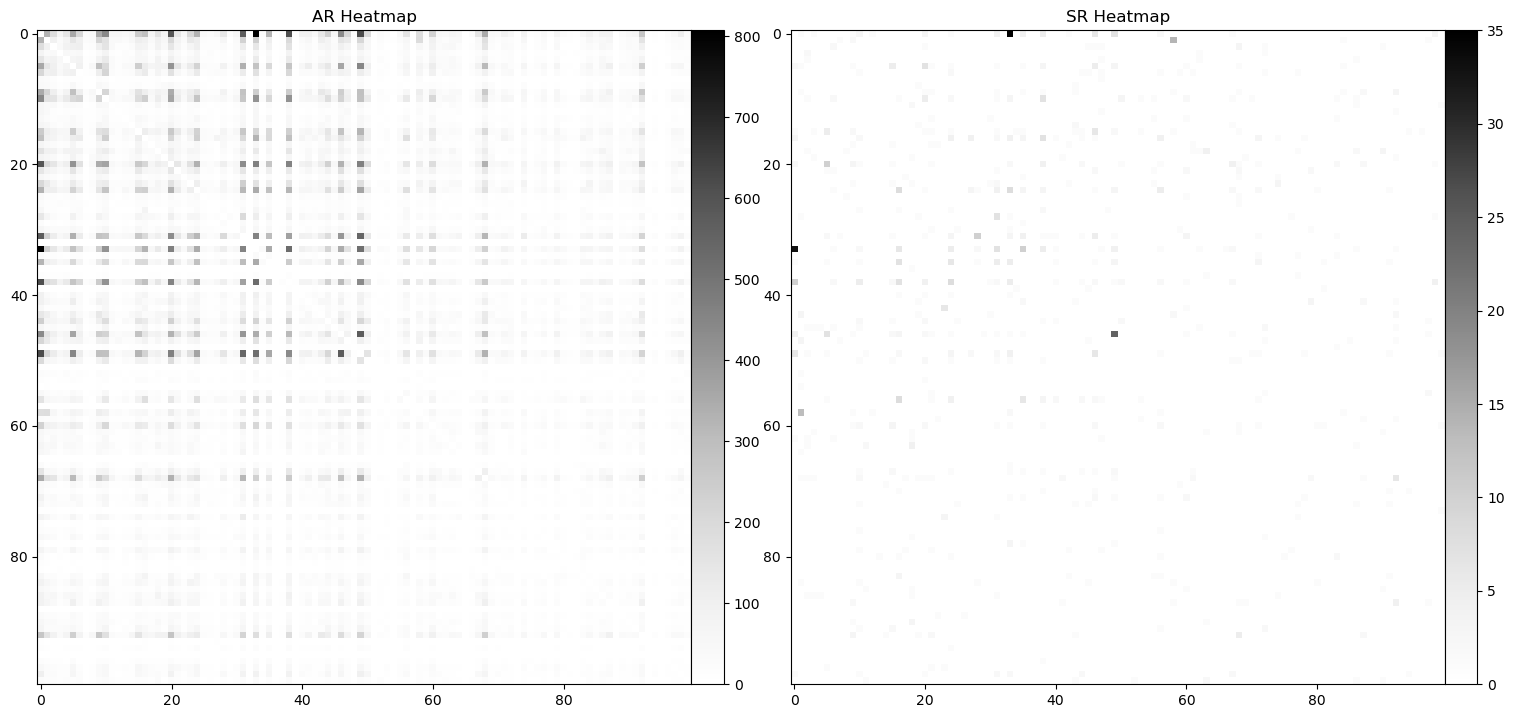

In [29]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(15, 7))

im0 = ax[0].imshow(ar_model.rules[:100, :100].toarray(), cmap='Greys')
ax[0].set_title('AR Heatmap')
divider0 = make_axes_locatable(ax[0])
cax0 = divider0.append_axes("right", size="5%", pad=0.0)
fig.colorbar(im0, ax=ax[0], cax=cax0)

im1 = ax[1].imshow(sr_model.rules[:100, :100].toarray(), cmap='Greys')
ax[1].set_title('SR Heatmap')
divider1 = make_axes_locatable(ax[1])
cax1 = divider1.append_axes("right", size="5%", pad=0.0)
fig.colorbar(im1, ax=ax[1], cax=cax1)

plt.show()

In [30]:
from scipy.sparse.linalg import norm

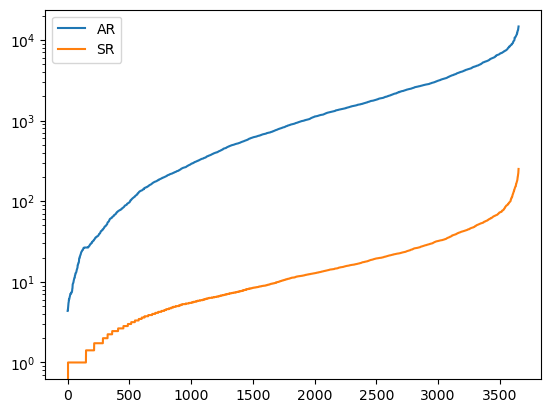

In [31]:
plt.semilogy(sorted(norm(ar_model.rules, axis=1)), label='AR')
plt.semilogy(sorted(norm(sr_model.rules, axis=1)), label='SR')
plt.legend()
plt.show()